In [ ]:
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Activation,
                                     Conv2D,
                                     Conv2DTranspose,
                                     Dense,
                                     GlobalMaxPooling2D,
                                     Input,
                                     LeakyReLU,
                                     Reshape)
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import backend as K

In [ ]:
def build_discriminator():
    x = Input(shape=(28, 28, 1))

    hidden = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding="same")(x)
    hidden = LeakyReLU(alpha = 0.2)(hidden)

    hidden = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding="same")(hidden)
    hidden = LeakyReLU(alpha = 0.2)(hidden)
    hidden = GlobalMaxPooling2D()(hidden)

    y = Dense(1)(hidden)

    return Model(inputs=x, outputs=y)
    
discriminator = build_discriminator()
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129   

In [ ]:
latent_dim = 128
def build_generator(latent_dim):
    x = Input(shape=(latent_dim, ))

    hidden = Dense(7 * 7 * 128)(x)
    hidden = LeakyReLU(alpha = 0.2)(hidden)
    hidden = Reshape((7, 7, 128))(hidden)

    hidden = Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding="same")(hidden)
    hidden = LeakyReLU(alpha = 0.2)(hidden)

    hidden = Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding="same")(hidden)
    hidden = LeakyReLU(alpha = 0.2)(hidden)

    y = Conv2D(1, (7, 7), padding="same", activation="sigmoid")(hidden)

    return Model(inputs=x, outputs=y)

generator = build_generator(latent_dim)
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              809088    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       147584    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       1475

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim, batch_size, save_dir):
        super(CustomCallback, self).__init__()
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.save_dir = save_dir

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        # Sample the latent space
        latent_vectors = tf.random.normal(shape=(self.batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.model(latent_vectors)
        # Save them
        img = tf.keras.preprocessing.image.array_to_img(
            generated_images[np.random.randint(0, self.batch_size)] * 255.0,
            scale=False
        )
        img.save(os.path.join(self.save_dir, f"GAN_img_{epoch:02d}.png"))

In [ ]:
class CustomModel(tf.keras.Model):
    def __init__(self, generator, discriminator, batch_size, latent_dim, **kwargs):
        super(CustomModel, self).__init__(**kwargs)

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.latent_dim = latent_dim

        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

        self.generator_opt = keras.optimizers.Adam(learning_rate=0.0004)
        self.discriminator_opt = keras.optimizers.Adam(learning_rate=0.0003)

        self.g_loss = tf.keras.metrics.Mean(name='gloss')
        self.d_loss = tf.keras.metrics.Mean(name='dloss')

    @property
    def metrics(self):
        return [
            self.g_loss,
            self.d_loss
        ]

    @tf.function
    def call(self, input):
        output = self.generator(input)
        return output

    @tf.function
    def test_step(self, data):
        return {}

    @tf.function
    def train_step(self, real_images):
        # Generate fake dataset
        # Sample the latent space
        latent_vectors = tf.random.normal(shape=(self.batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(latent_vectors)
        x = tf.concat([generated_images, real_images], axis=0)
        # 1 - Fake & 0 - Real
        y = tf.concat(
            [tf.ones((self.batch_size, 1)), tf.zeros((self.batch_size, 1))], axis=0
        )
        # Add noise to the labels
        y += 0.05 * tf.random.uniform(y.shape)

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(x)
            d_loss = self.loss_fn(y, predictions)
        # Backpropagation
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        # Weigth update
        self.discriminator_opt.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample the latent space
        latent_vectors = tf.random.normal(shape=(self.batch_size, self.latent_dim))

        # Train the generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(latent_vectors))
            # Loss is lower when the discriminator predicts that generated imgs are real.
            g_loss = self.loss_fn(tf.zeros((batch_size, 1)), predictions)
        # Backpropagation
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        # Weigth update
        self.generator_opt.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update training metric
        self.d_loss.update_state(d_loss)
        self.g_loss.update_state(g_loss)
        return {
            "Generator CCE":     self.g_loss.result(),
            "Discriminator CCE": self.d_loss.result(),
        }

In [ ]:
save_dir = "./"

batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True)

In [ ]:
cm = CustomModel(build_generator(latent_dim), build_discriminator(), batch_size, latent_dim)
cm.compile()

epochs = 50
history = cm.fit(dataset,
                 epochs=epochs,
                 callbacks=[CustomCallback(latent_dim, batch_size, save_dir)],
)

Epoch 1/50
1093/1093 [==============================] - 33s 27ms/step - Generator CCE: 1.1586 - Discriminator CCE: 0.4794
Epoch 2/50
1093/1093 [==============================] - 29s 26ms/step - Generator CCE: 3.6796 - Discriminator CCE: 0.2739
Epoch 3/50
1093/1093 [==============================] - 29s 26ms/step - Generator CCE: 0.9236 - Discriminator CCE: 0.6604
Epoch 4/50
1093/1093 [==============================] - 29s 27ms/step - Generator CCE: 0.9065 - Discriminator CCE: 0.6484
Epoch 5/50
1093/1093 [==============================] - 29s 26ms/step - Generator CCE: 0.9993 - Discriminator CCE: 0.6087
Epoch 6/50
1093/1093 [==============================] - 29s 26ms/step - Generator CCE: 1.0383 - Discriminator CCE: 0.5879
Epoch 7/50
1093/1093 [==============================] - 29s 27ms/step - Generator CCE: 1.0916 - Discriminator CCE: 0.5633
Epoch 8/50
1093/1093 [==============================] - 29s 27ms/step - Generator CCE: 1.1105 - Discriminator CCE: 0.5476
Epoch 9/50
1093/1093 [==

Text(0.5, 1.0, 'Epoch: 49')

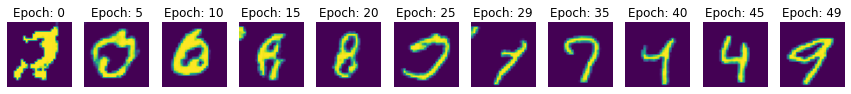

In [ ]:
import glob 

imgs_path = glob.glob(os.path.join(save_dir, "GAN_img_*.png"))
imgs_path.sort()

from PIL import Image

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11) = plt.subplots(1, 11, figsize=(15,15))
g = ax1.imshow(Image.open(imgs_path[0])); ax1.axis('off'); ax1.set_title(f'Epoch: {0}')
g = ax2.imshow(Image.open(imgs_path[5])); ax2.axis('off'); ax2.set_title(f'Epoch: {5}')
g = ax3.imshow(Image.open(imgs_path[10])); ax3.axis('off'); ax3.set_title(f'Epoch: {10}')
g = ax4.imshow(Image.open(imgs_path[15])); ax4.axis('off'); ax4.set_title(f'Epoch: {15}')
g = ax5.imshow(Image.open(imgs_path[20])); ax5.axis('off'); ax5.set_title(f'Epoch: {20}')
g = ax6.imshow(Image.open(imgs_path[25])); ax6.axis('off'); ax6.set_title(f'Epoch: {25}')
g = ax7.imshow(Image.open(imgs_path[29])); ax7.axis('off'); ax7.set_title(f'Epoch: {29}')
g = ax8.imshow(Image.open(imgs_path[35])); ax8.axis('off'); ax8.set_title(f'Epoch: {35}')
g = ax9.imshow(Image.open(imgs_path[40])); ax9.axis('off'); ax9.set_title(f'Epoch: {40}')
g = ax10.imshow(Image.open(imgs_path[45])); ax10.axis('off'); ax10.set_title(f'Epoch: {45}')
g = ax11.imshow(Image.open(imgs_path[49])); ax11.axis('off'); ax11.set_title(f'Epoch: {49}')